### Import libraries

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import levene
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import pmdarima as pm
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

### Data preparation

In [3]:
file_path = "../Data/Final data/df_daily.csv"
air_pollution = pd.read_csv(file_path)
air_pollution.head()

,date,pm2.5_avg,humidity,temperature,pressure
0,2021-06-19 00:00:00+00:00,27.641667,23.000,87.800,860.762
1,2021-06-20 00:00:00+00:00,12.400000,19.000,87.100,859.215
2,2021-06-21 00:00:00+00:00,1.808333,18.000,94.000,861.885
3,2021-10-08 00:00:00+00:00,22.733333,50.433,54.767,904.738
4,2021-10-09 00:00:00+00:00,36.825107,52.567,52.600,904.770


### Correlation with temperature and humidity

In [4]:
df = air_pollution[['pm2.5_avg', 'temperature', 'humidity']]
correlations = df.corr(method='pearson')
print(correlations)

             pm2.5_avg  temperature  humidity
pm2.5_avg     1.000000    -0.511972  0.380351
temperature  -0.511972     1.000000 -0.419849
humidity      0.380351    -0.419849  1.000000


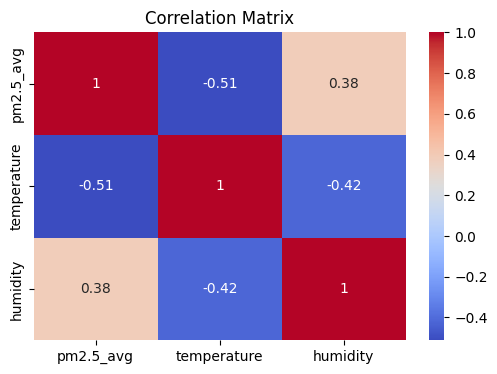

In [5]:
plt.figure(figsize=(6,4))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Autocorrelation

In [6]:
df_time_series = air_pollution[['date', 'pm2.5_avg', 'temperature', 'humidity']]
df_time_series['date'] = pd.to_datetime(df_time_series['date'])
df_time_series.set_index('date', inplace=True)
df_time_series = df_time_series.sort_index() 
df_time_series.head()

,pm2.5_avg,temperature,humidity
date,,,
2021-06-19 00:00:00+00:00,27.641667,87.800,23.000
2021-06-20 00:00:00+00:00,12.400000,87.100,19.000
2021-06-21 00:00:00+00:00,1.808333,94.000,18.000
2021-10-08 00:00:00+00:00,22.733333,54.767,50.433
2021-10-09 00:00:00+00:00,36.825107,52.600,52.567


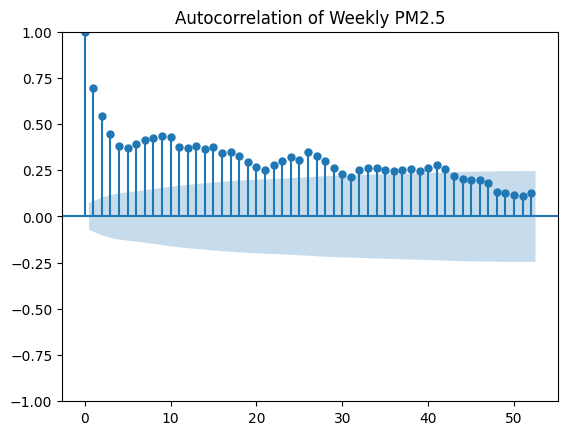

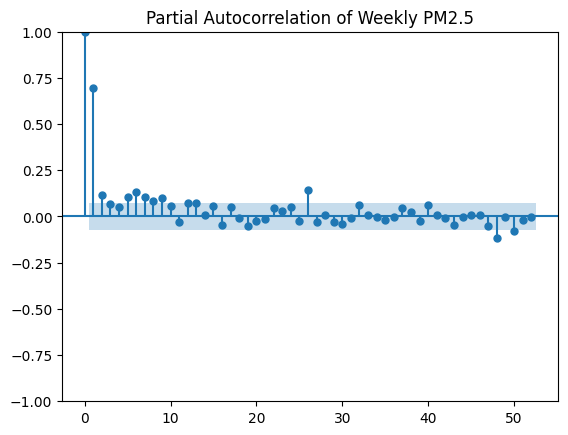

In [7]:
plot_acf(df_time_series['pm2.5_avg'].dropna(), lags=52)
plt.title('Autocorrelation of Weekly PM2.5')
plt.show()

plot_pacf(df_time_series['pm2.5_avg'].dropna(), lags=52)
plt.title('Partial Autocorrelation of Weekly PM2.5')
plt.show()


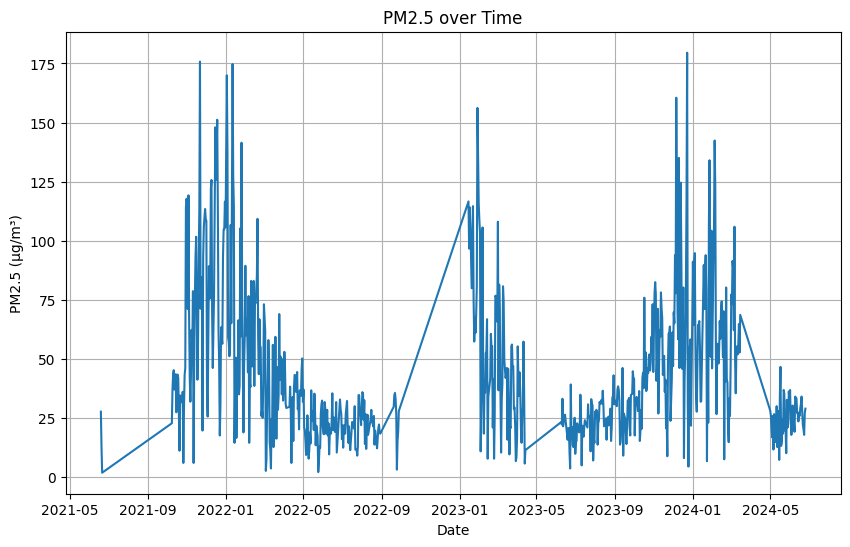

In [8]:
plt.figure(figsize=(10,6))
plt.tight_layout()  # Add this before saving
plt.plot(df_time_series['pm2.5_avg'], label='PM2.5')
plt.title('PM2.5 over Time')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True)
plt.show()

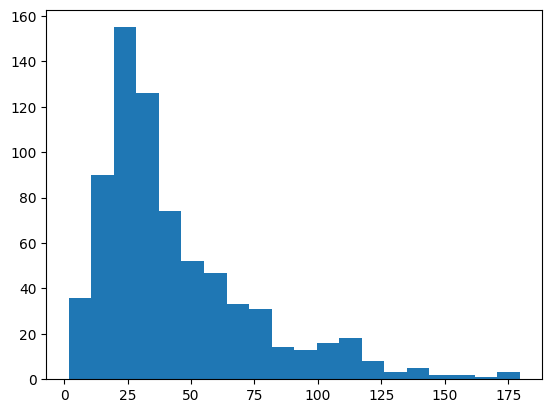

In [9]:
plt.hist(air_pollution['pm2.5_avg'], bins=20)
plt.show()

### Time series decomposition

In [10]:
midpoint = len(df_time_series) // 2
early = df_time_series['pm2.5_avg'].iloc[:midpoint]
late = df_time_series['pm2.5_avg'].iloc[midpoint:]

stat, p_value = levene(early, late)
print(f"Levene test p-value: {p_value}")

Levene test p-value: 7.821107328149119e-05


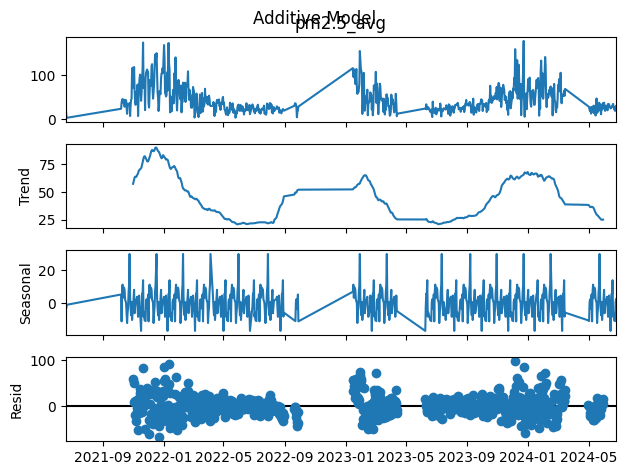

In [11]:
additive_decomposition = seasonal_decompose(df_time_series['pm2.5_avg'], model='additive', period=52)

additive_decomposition.plot()
plt.suptitle('Additive Model')
plt.show()

### Working with residuals

In [12]:
resid = additive_decomposition.resid.dropna()
ljung_result = acorr_ljungbox(resid, lags=[10], return_df=True)
print(ljung_result)

       lb_stat     lb_pvalue
10  193.264248  4.089202e-36


In [13]:
model = pm.auto_arima(df_time_series['pm2.5_avg'], 
                      seasonal=True, 
                      m=52,                      
                      trace=True,                
                      error_action='ignore',     
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=19.68 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=6722.844, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=6675.639, Time=2.74 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=6647.434, Time=3.75 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=6720.844, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=6647.868, Time=0.08 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=7.44 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=6646.954, Time=21.84 sec
 ARIMA(0,1,1)(1,0,2)[52] intercept   : AIC=inf, Time=56.69 sec
 ARIMA(0,1,0)(0,0,2)[52] intercept   : AIC=6719.766, Time=16.15 sec
 ARIMA(1,1,1)(0,0,2)[52] intercept   : AIC=6560.297, Time=32.65 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AIC=6559.450, Time=6.12 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=6559.902, Time=0.11 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=12.94 sec
 ARIMA(1,1,1)(1,0,0)[52] intercep

In [14]:
df_time_series['weekly_diff'] = df_time_series['pm2.5_avg'].diff()

In [15]:
mean_change = df_time_series['weekly_diff'].mean()
std_change = df_time_series['weekly_diff'].std()
max_change = df_time_series['weekly_diff'].abs().max()

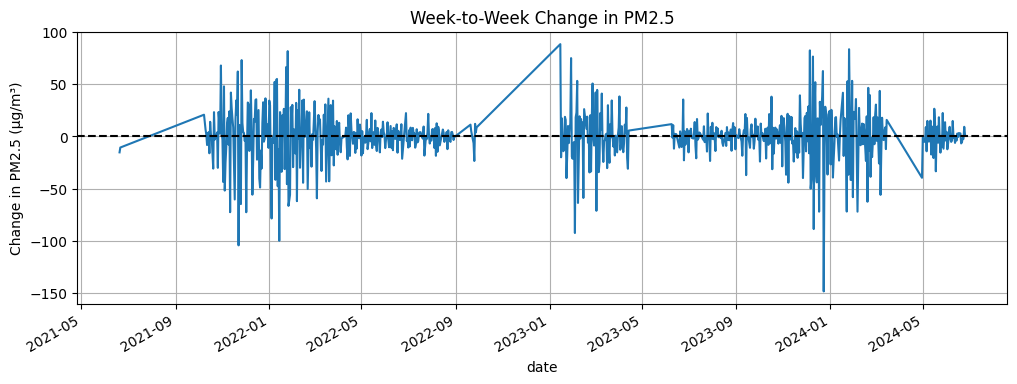

In [16]:
df_time_series['weekly_diff'].plot(figsize=(12,4), title='Week-to-Week Change in PM2.5')
plt.axhline(0, color='black', linestyle='--')
plt.ylabel('Change in PM2.5 (µg/m³)')
plt.grid(True)
plt.show()


**Interpretation**

- The weekly changes in PM2.5 range roughly from -65 to +65 µg/m³. This shows that air quality can shift dramatically in just one week, especially during winter.
- The largest spikes and dips occur in late fall to early spring (around November to February), each year.
- From roughly April to September each year, changes are mostly small and clustered around 0 µg/m³.
- Most weekly differences are centered around the zero line, which is typical of stationary series with seasonal variation.

*PM2.5 levels in Yerevan show high short-term variability, especially during colder months.*

# SARIMA model

In [17]:
n_periods = 913
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

last_date = df_time_series.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_periods, freq='D')

sarima_forecast = pd.DataFrame({
    'Date': future_dates,
    'SARIMA': forecast,
    'Lower_CI': conf_int[:, 0],
    'Upper_CI': conf_int[:, 1]
}).set_index('Date')

sarima_forecast


,SARIMA,Lower_CI,Upper_CI
Date,,,
2024-06-26 00:00:00+00:00,27.436283,-15.139017,70.011584
2024-06-27 00:00:00+00:00,25.554420,-23.183769,74.292609
2024-06-28 00:00:00+00:00,26.020116,-24.881406,76.921639
2024-06-29 00:00:00+00:00,25.516793,-26.425602,77.459189
2024-06-30 00:00:00+00:00,25.099534,-27.496683,77.695750
...,...,...,...
2026-12-21 00:00:00+00:00,25.513987,-184.482478,235.510452
2026-12-22 00:00:00+00:00,25.513987,-184.591811,235.619785
2026-12-23 00:00:00+00:00,25.513987,-184.701086,235.729061


In [18]:
y = df_time_series['pm2.5_avg']
n_test = 80
y_train = y[:-n_test]
y_test = y[-n_test:]

forecast, conf_int = model.predict(n_periods=n_test, return_conf_int=True)

mae_sarima = mean_absolute_error(y_test, forecast)
rmse_sarima = sqrt(mean_squared_error(y_test, forecast))

print(f"Mean Absolute Error (MAE) for SARIMA model: {mae_sarima:.2f}")
print(f"Root Mean Squared Error (RMSE) for SARIMA model: {rmse_sarima:.2f}")


Mean Absolute Error (MAE) for SARIMA model: 13.58
Root Mean Squared Error (RMSE) for SARIMA model: 21.38


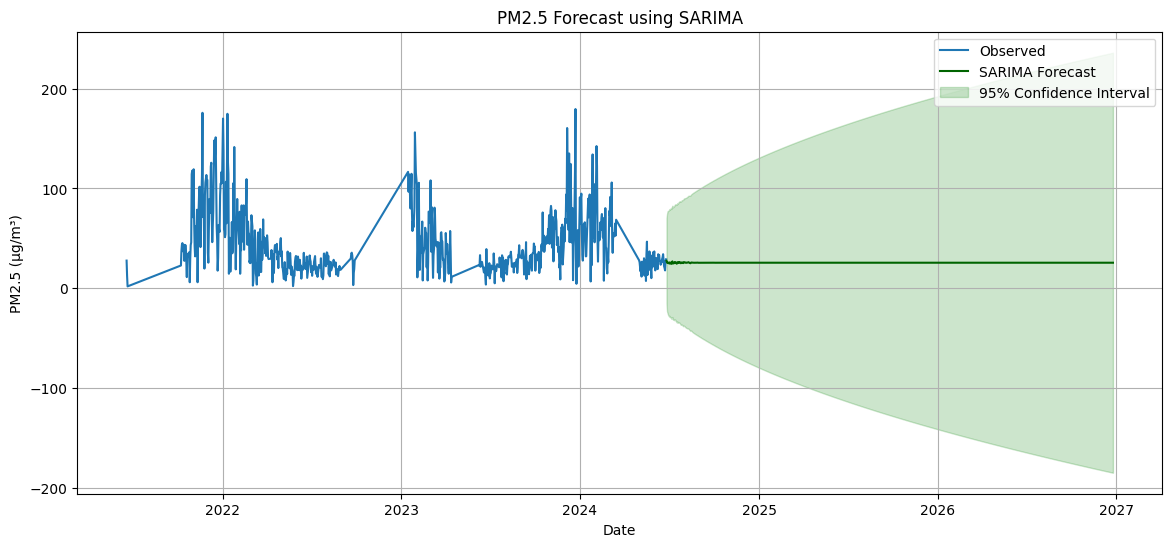

In [19]:
plt.figure(figsize=(14, 6))
plt.plot(df_time_series['pm2.5_avg'], label='Observed')
plt.plot(sarima_forecast['SARIMA'], label='SARIMA Forecast', color='darkgreen')
plt.fill_between(sarima_forecast.index, sarima_forecast['Lower_CI'], sarima_forecast['Upper_CI'],
                 color='green', alpha=0.2, label='95% Confidence Interval')
plt.title('PM2.5 Forecast using SARIMA')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.grid(True)
plt.show()

# Exponential Smoothing

In [20]:
ets_model = ExponentialSmoothing(
    df_time_series['pm2.5_avg'],
    trend='add',
    seasonal='add',
    seasonal_periods=52
).fit()

n_periods = 913
ets_forecast = ets_model.forecast(n_periods)

last_date = df_time_series.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=n_periods, freq='D')

residuals = ets_model.resid
residual_std = np.std(residuals)

z_score = norm.ppf(0.975)  

lower_ci = ets_forecast - z_score * residual_std
upper_ci = ets_forecast + z_score * residual_std

ets_pred = pd.DataFrame({
    'Date': future_dates,
    'ETS': ets_forecast.values,
    'Lower_CI': lower_ci.values,
    'Upper_CI': upper_ci.values
}).set_index('Date')

ets_forecast = ets_model.forecast(n_test)

mae_ets = mean_absolute_error(y_test, ets_forecast)
rmse_ets = sqrt(mean_squared_error(y_test, ets_forecast))

print(f"Mean Absolute Error (MAE) for ETS model: {mae_ets:.2f}")
print(f"Root Mean Squared Error (RMSE) for ETS model: {rmse_ets:.2f}")


Mean Absolute Error (MAE) for ETS model: 15.79
Root Mean Squared Error (RMSE) for ETS model: 23.07


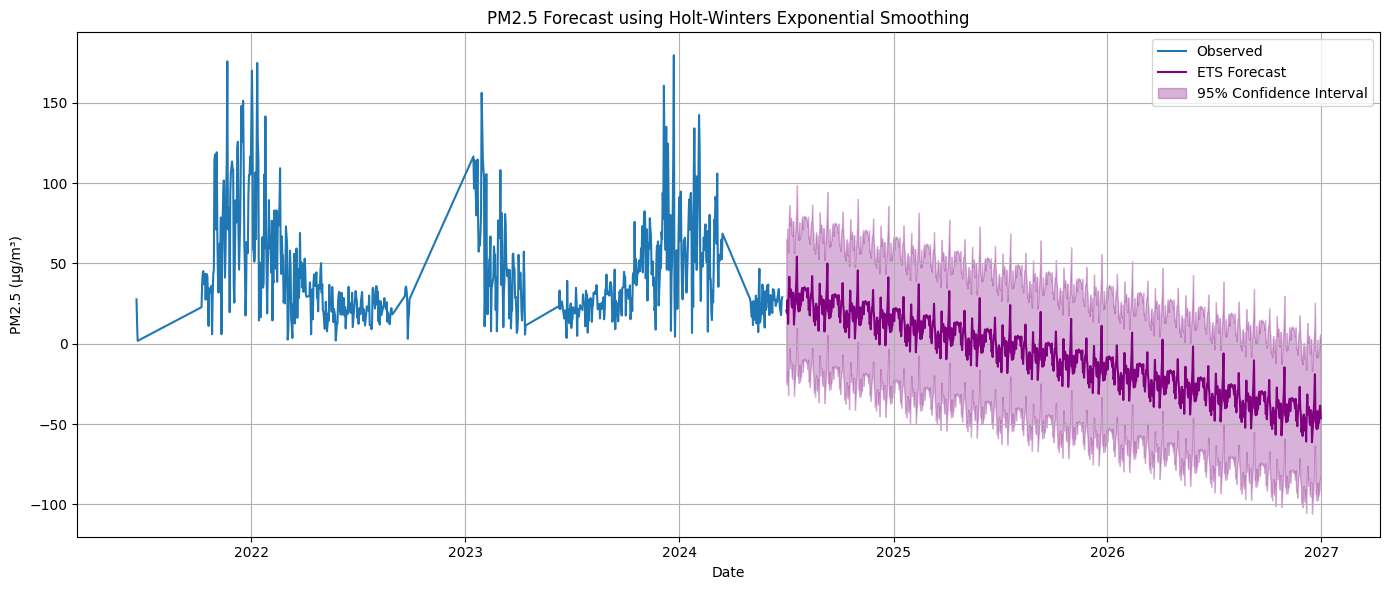

In [21]:
plt.figure(figsize=(14, 6))
plt.plot(df_time_series['pm2.5_avg'], label='Observed')
plt.plot(ets_pred['ETS'], label='ETS Forecast', color='purple')

plt.fill_between(
    ets_pred.index,
    ets_pred['Lower_CI'],
    ets_pred['Upper_CI'],
    color='purple',
    alpha=0.3,
    label='95% Confidence Interval'
)

plt.title('PM2.5 Forecast using Holt-Winters Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# XGBoost

In [22]:
n_periods = 913
df_time_series['pm2.5_lag1'] = df_time_series['pm2.5_avg'].shift(1)
df_time_series['pm2.5_lag2'] = df_time_series['pm2.5_avg'].shift(2)

df_time_series['month'] = df_time_series.index.month
df_time_series['week'] = df_time_series.index.isocalendar().week
df_time_series['dayofweek'] = df_time_series.index.dayofweek

df_time_series = df_time_series.dropna()

X = df_time_series[['pm2.5_lag1', 'pm2.5_lag2', 'month', 'week', 'dayofweek']]
y = df_time_series['pm2.5_avg']

xgb = XGBRegressor()
xgb.fit(X, y)

df_time_series['XGB_Pred'] = xgb.predict(X)

last_lag1 = df_time_series['pm2.5_avg'].iloc[-1]
last_lag2 = df_time_series['pm2.5_avg'].iloc[-2]

future_dates = pd.date_range(start=df_time_series.index[-1] + pd.Timedelta(weeks=1), periods=n_periods, freq='D')
xgb_forecast = []

for date in future_dates:
    month = date.month
    week = date.isocalendar().week
    dayofweek = date.dayofweek

    features = np.array([[last_lag1, last_lag2, month, week, dayofweek]])
    pred = xgb.predict(features)[0]
    xgb_forecast.append(pred)

    last_lag2 = last_lag1
    last_lag1 = pred


xgb_forecast_df = pd.DataFrame({
    'Date': future_dates,
    'XGB_70W_Forecast': xgb_forecast
}).set_index('Date')

X_train, X_test = X[:-n_test], X[-n_test:]
y_train, y_test = y[:-n_test], y[-n_test:]

y_pred = xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred)
rmse_xgb = sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE) for XGBoost model: {mae_xgb:.2f}")
print(f"Root Mean Squared Error (RMSE) for XGBoost model: {rmse_xgb:.2f}")

residuals = y_test - y_pred
residual_std = np.std(residuals, ddof=1)
residual_std = max(residual_std, 1.0) 

z_score = norm.ppf(0.975)  # 95% CI

lower_ci = np.array(xgb_forecast) - z_score * residual_std
upper_ci = np.array(xgb_forecast) + z_score * residual_std

xgb_forecast_df['Lower_CI'] = lower_ci
xgb_forecast_df['Upper_CI'] = upper_ci


Mean Absolute Error (MAE) for XGBoost model: 1.18
Root Mean Squared Error (RMSE) for XGBoost model: 1.63


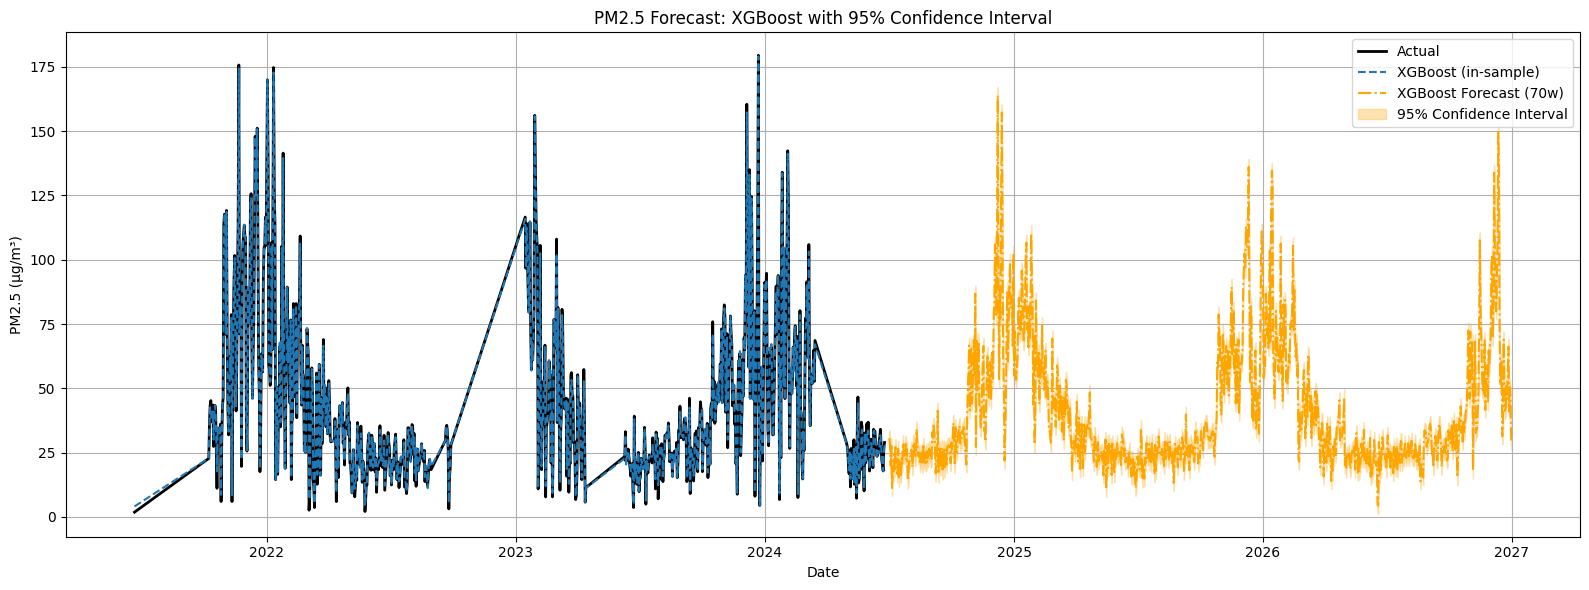

In [23]:
plt.figure(figsize=(16, 6))

plt.plot(df_time_series.index, df_time_series['pm2.5_avg'], label='Actual', color='black', linewidth=2)
plt.plot(df_time_series.index, df_time_series['XGB_Pred'], label='XGBoost (in-sample)', linestyle='--')
plt.plot(xgb_forecast_df.index, xgb_forecast_df['XGB_70W_Forecast'], label='XGBoost Forecast (70w)', linestyle='-.', color='orange')

# Shaded confidence interval
plt.fill_between(
    xgb_forecast_df.index,
    xgb_forecast_df['Lower_CI'],
    xgb_forecast_df['Upper_CI'],
    color='orange',
    alpha=0.3,
    label='95% Confidence Interval'
)

plt.title('PM2.5 Forecast: XGBoost with 95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
residuals = df_time_series['pm2.5_avg'] - df_time_series['XGB_Pred']
residual_std = np.std(residuals)

z_score = norm.ppf(0.975)  
xgb_forecast = np.array(xgb_forecast)
lower_bound = xgb_forecast - z_score * residual_std
upper_bound = xgb_forecast + z_score * residual_std

xgboost_pred = pd.DataFrame({
    'Date': future_dates,
    'XHBoost': xgb_forecast,
    'Lower_Bound': lower_bound,
    'Upper_Bound': upper_bound
})

xgboost_pred = xgboost_pred.set_index('Date')
print(xgboost_pred.head())


                             XHBoost  Lower_Bound  Upper_Bound
Date                                                          
2024-07-02 00:00:00+00:00  30.575687    27.802792    33.348583
2024-07-03 00:00:00+00:00  27.929382    25.156487    30.702278
2024-07-04 00:00:00+00:00  19.947035    17.174139    22.719931
2024-07-05 00:00:00+00:00  27.536077    24.763182    30.308973
2024-07-06 00:00:00+00:00  11.227511     8.454616    14.000407


# SARIMAX including exogenous inputs of temperature and humidity

In [25]:
exog_vars = df_time_series[['temperature', 'humidity']]  
exog_vars = exog_vars.loc[y.index]  

scaler = StandardScaler()
exog_scaled = pd.DataFrame(
    scaler.fit_transform(exog_vars),
    columns=exog_vars.columns,
    index=exog_vars.index
)

model_sarimax = SARIMAX(
    endog=y,
    exog=exog_scaled,
    order=(3, 0, 2),
    seasonal_order=(0, 0, 1, 52),
    enforce_stationarity=True,
    enforce_invertibility=True
)
results_sarimax = model_sarimax.fit(disp=False, maxiter=50)

forecast_weeks = 913
last_date = y.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=forecast_weeks, freq='D')

last_exog_row = exog_scaled.iloc[-1]
future_exog = pd.DataFrame(
    [last_exog_row.values] * forecast_weeks,
    columns=exog_scaled.columns,
    index=future_dates
)

forecast_sarimax = results_sarimax.get_forecast(steps=forecast_weeks, exog=future_exog)
sarimax_forecast_values = forecast_sarimax.predicted_mean
conf_int = forecast_sarimax.conf_int()

sarimax_pred = pd.DataFrame({
    'Date': future_dates,
    'SARIMAX_exogeneous': sarimax_forecast_values.values,
    'Lower_Bound': conf_int.iloc[:, 0].values,
    'Upper_Bound': conf_int.iloc[:, 1].values
}).set_index('Date')

y_train, y_test = y[:-n_test], y[-n_test:]
exog_train, exog_test = exog_scaled.loc[y_train.index], exog_scaled.loc[y_test.index]

forecast_sarimax = results_sarimax.get_forecast(steps=n_test, exog=exog_test)
y_pred = forecast_sarimax.predicted_mean

mae_sarimax = mean_absolute_error(y_test, y_pred)
rmse_sarimax = sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE) for SARIMAX model: {mae_sarimax:.2f}")
print(f"Root Mean Squared Error (RMSE) for SARIMAX model: {rmse_sarimax:.2f}")


Mean Absolute Error (MAE) for SARIMAX model: 17.27
Root Mean Squared Error (RMSE) for SARIMAX model: 26.32


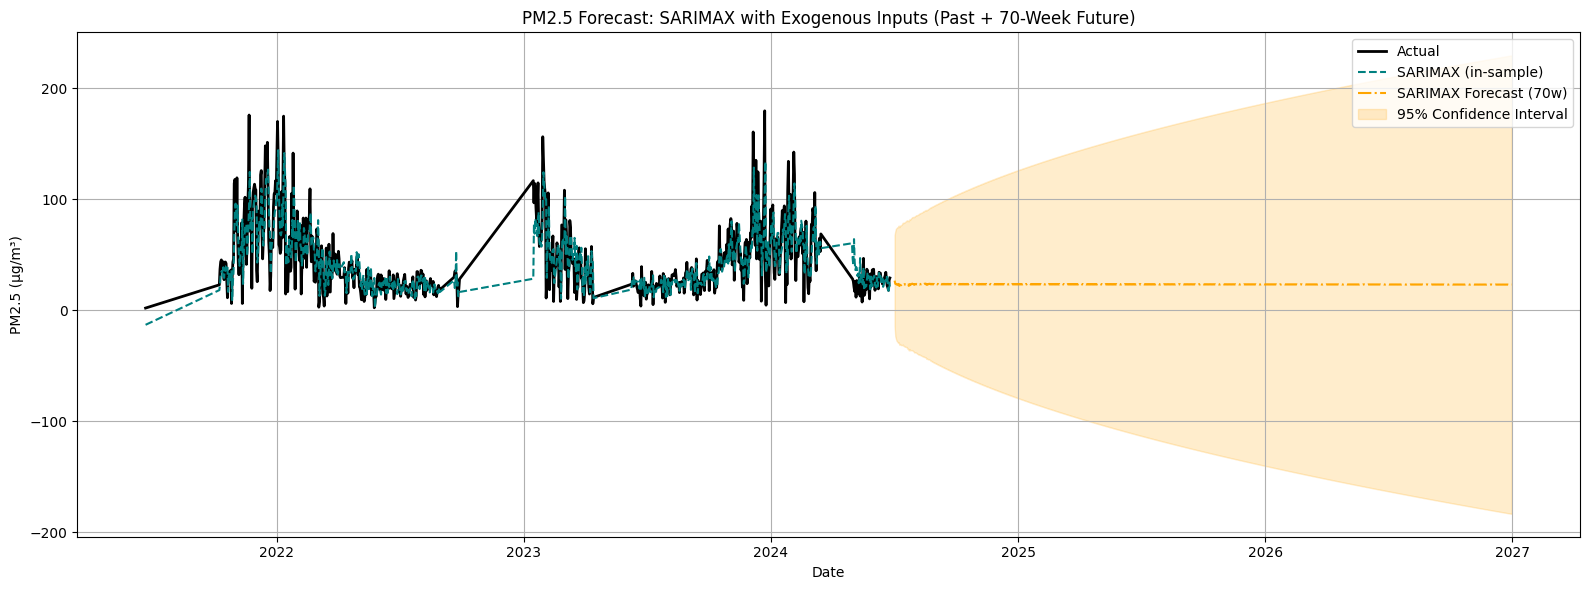

In [26]:
plt.figure(figsize=(16, 6))
plt.plot(y.index, y, label='Actual', color='black', linewidth=2)
plt.plot(y.index, results_sarimax.fittedvalues, label='SARIMAX (in-sample)', linestyle='--', color='teal')
plt.plot(sarimax_pred.index, sarimax_pred['SARIMAX_exogeneous'], label='SARIMAX Forecast (70w)', linestyle='-.', color='orange')
plt.fill_between(sarimax_pred.index, sarimax_pred['Lower_Bound'], sarimax_pred['Upper_Bound'],
                 color='orange', alpha=0.2, label='95% Confidence Interval')
plt.title('PM2.5 Forecast: SARIMAX with Exogenous Inputs (Past + 70-Week Future)')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Random forest

In [27]:
df_rf = df_time_series.copy()
df_rf['pm2.5_lag1'] = df_rf['pm2.5_avg'].shift(1)
df_rf['pm2.5_lag2'] = df_rf['pm2.5_avg'].shift(2)

df_rf['month'] = df_rf.index.month
df_rf['week'] = df_rf.index.isocalendar().week
df_rf['dayofweek'] = df_rf.index.dayofweek

df_rf = df_rf.dropna()

X_rf = df_rf[['pm2.5_lag1', 'pm2.5_lag2', 'month', 'week', 'dayofweek']]
y_rf = df_rf['pm2.5_avg']

rf = RandomForestRegressor()
rf.fit(X_rf, y_rf)

df_rf['RF_Pred'] = rf.predict(X_rf)

forecast_weeks = 913
last_lag1_rf = df_rf['pm2.5_avg'].iloc[-1]
last_lag2_rf = df_rf['pm2.5_avg'].iloc[-2]

future_dates = pd.date_range(start=df_rf.index[-1] + pd.Timedelta(weeks=1), periods=forecast_weeks, freq='D')
rf_forecast = []

for date in future_dates:
    month = date.month
    week = date.isocalendar().week
    dayofweek = date.dayofweek

    features = np.array([[last_lag1_rf, last_lag2_rf, month, week, dayofweek]])
    pred = rf.predict(features)[0]
    rf_forecast.append(pred)

    last_lag2_rf = last_lag1_rf
    last_lag1_rf = pred

rf_forecast = np.array(rf_forecast)

residuals_rf = df_rf['pm2.5_avg'] - df_rf['RF_Pred']
residual_std_rf = np.std(residuals_rf)
z_score = norm.ppf(0.975)

lower_bound_rf = rf_forecast - z_score * residual_std_rf
upper_bound_rf = rf_forecast + z_score * residual_std_rf

random_forest_pred = pd.DataFrame({
    'Date': future_dates,
    'RF': rf_forecast,
    'Lower_Bound': lower_bound_rf,
    'Upper_Bound': upper_bound_rf
}).set_index('Date')

X_train_rf, X_test_rf = X_rf[:-n_test], X_rf[-n_test:]
y_train_rf, y_test_rf = y_rf[:-n_test], y_rf[-n_test:]
rf.fit(X_train_rf, y_train_rf)
y_pred_rf = rf.predict(X_test_rf)

mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)
rmse_rf = sqrt(mean_squared_error(y_test_rf, y_pred_rf))

print(f"Mean Absolute Error (MAE) for Random Forest: {mae_rf:.2f}")
print(f"Root Mean Squared Error (RMSE) for Random Forest: {rmse_rf:.2f}")


Mean Absolute Error (MAE) for Random Forest: 10.84
Root Mean Squared Error (RMSE) for Random Forest: 14.64


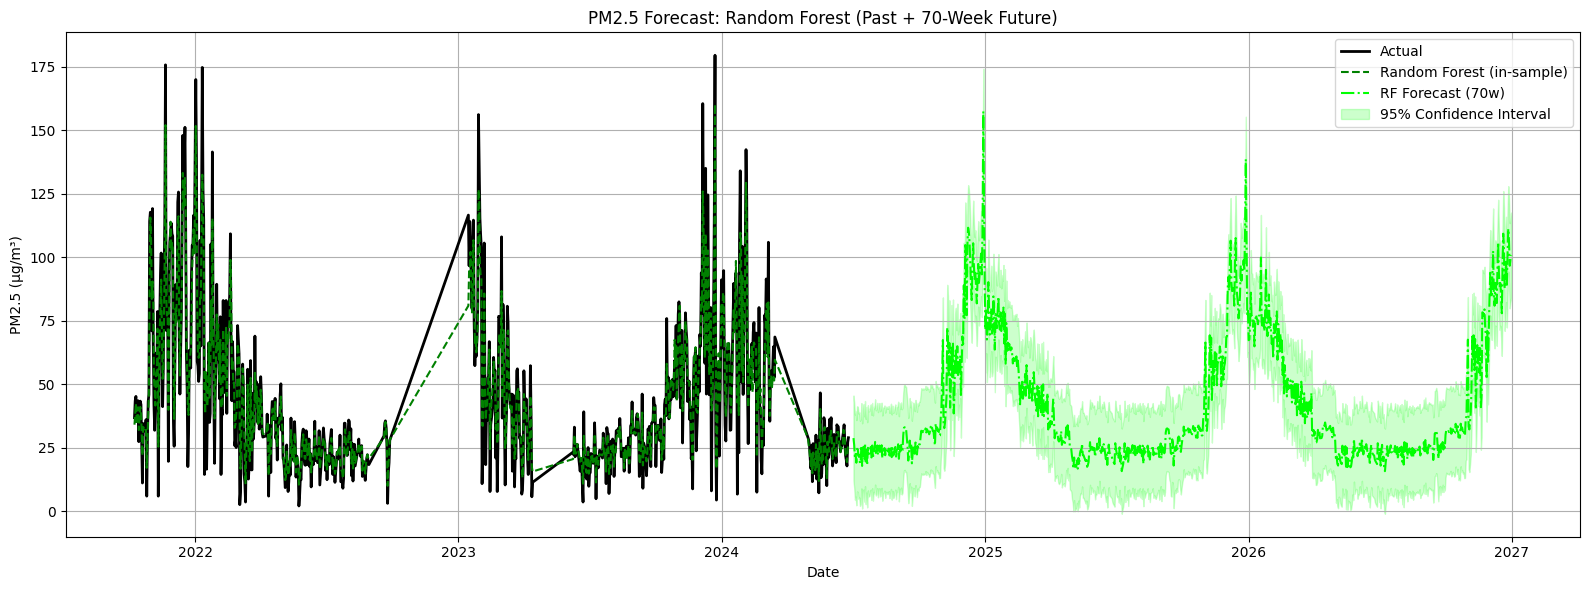

In [28]:
plt.figure(figsize=(16, 6))
plt.plot(df_rf.index, df_rf['pm2.5_avg'], label='Actual', color='black', linewidth=2)
plt.plot(df_rf.index, df_rf['RF_Pred'], label='Random Forest (in-sample)', linestyle='--', color='green')
plt.plot(random_forest_pred.index, random_forest_pred['RF'], label='RF Forecast (70w)', linestyle='-.', color='lime')
plt.fill_between(random_forest_pred.index, random_forest_pred['Lower_Bound'], random_forest_pred['Upper_Bound'],
                 color='lime', alpha=0.2, label='95% Confidence Interval')
plt.title('PM2.5 Forecast: Random Forest (Past + 70-Week Future)')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# SVR

In [29]:
df_svr = df_time_series.copy()
df_svr['pm2.5_lag1'] = df_svr['pm2.5_avg'].shift(1)
df_svr['pm2.5_lag2'] = df_svr['pm2.5_avg'].shift(2)

df_svr['month'] = df_svr.index.month
df_svr['week'] = df_svr.index.isocalendar().week
df_svr['dayofweek'] = df_svr.index.dayofweek

df_svr = df_svr.dropna()

X_svr = df_svr[['pm2.5_lag1', 'pm2.5_lag2', 'pm2.5_avg', 'month', 'week', 'dayofweek']]
y_svr = df_svr['pm2.5_avg']

svr = SVR()
svr.fit(X_svr, y_svr)

df_svr['SVR_Pred'] = svr.predict(X_svr)

forecast_weeks = 913
last_lag1_svr = df_svr['pm2.5_avg'].iloc[-1]
last_lag2_svr = df_svr['pm2.5_avg'].iloc[-2]

future_dates = pd.date_range(start=df_svr.index[-1] + pd.Timedelta(weeks=1), periods=forecast_weeks, freq='D')
svr_forecast = []

for date in future_dates:
    month = date.month
    week = date.isocalendar().week
    dayofweek = date.dayofweek

    features = np.array([[last_lag1_svr, last_lag2_svr, last_lag1_svr, month, week, dayofweek]])
    pred = svr.predict(features)[0]
    svr_forecast.append(pred)

    last_lag2_svr = last_lag1_svr
    last_lag1_svr = pred

residuals_svr = df_svr['pm2.5_avg'] - df_svr['SVR_Pred']
residual_std_svr = np.std(residuals_svr)
z_score = norm.ppf(0.975)

svr_forecast = np.array(svr_forecast)
lower_bound_svr = svr_forecast - z_score * residual_std_svr
upper_bound_svr = svr_forecast + z_score * residual_std_svr

svr_pred = pd.DataFrame({
    'Date': future_dates,
    'SVR': svr_forecast,
    'Lower_Bound': lower_bound_svr,
    'Upper_Bound': upper_bound_svr
}).set_index('Date')


X_train_svr, X_test_svr = X_svr[:-n_test], X_svr[-n_test:]
y_train_svr, y_test_svr = y_svr[:-n_test], y_svr[-n_test:]

svr.fit(X_train_svr, y_train_svr)

y_pred_svr = svr.predict(X_test_svr)

mae_svr = mean_absolute_error(y_test_svr, y_pred_svr)
rmse_svr = sqrt(mean_squared_error(y_test_svr, y_pred_svr))

print(f"Mean Absolute Error (MAE) for SVR: {mae_svr:.2f}")
print(f"Root Mean Squared Error (RMSE) for SVR: {rmse_svr:.2f}")


Mean Absolute Error (MAE) for SVR: 1.48
Root Mean Squared Error (RMSE) for SVR: 2.28


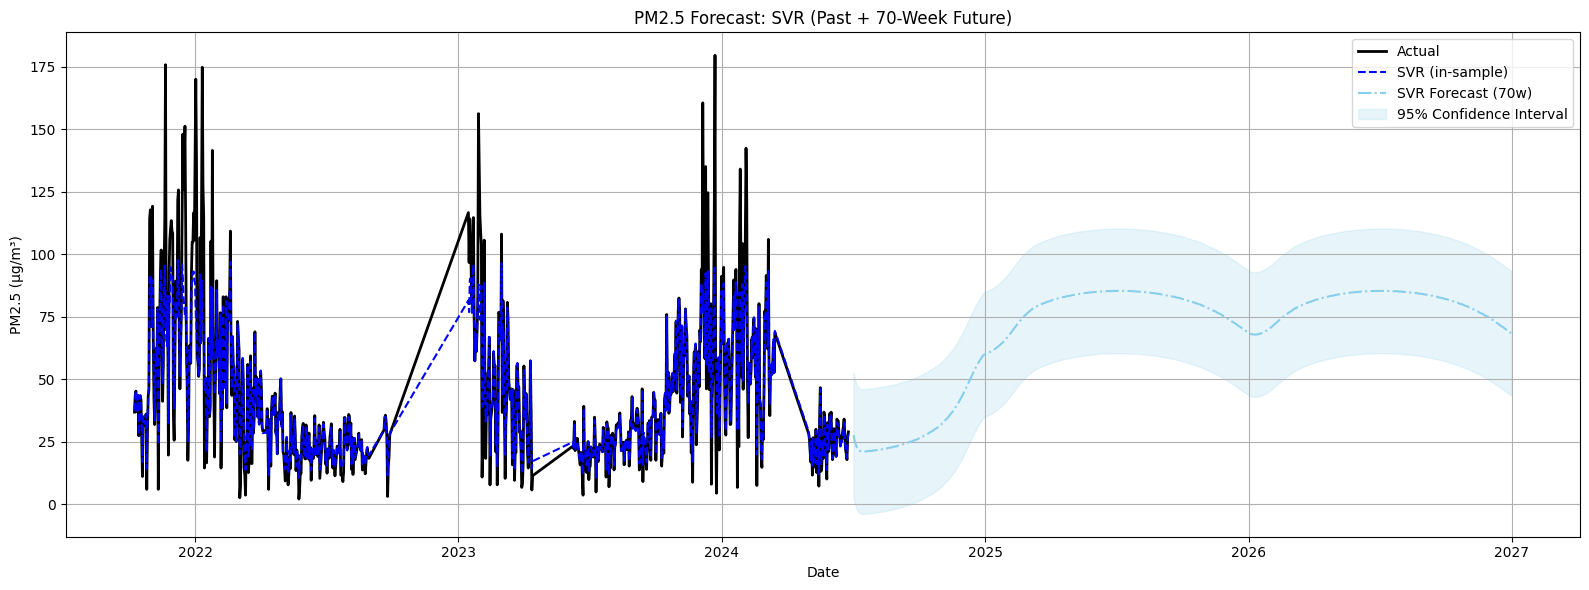

In [30]:
plt.figure(figsize=(16, 6))
plt.plot(df_svr.index, df_svr['pm2.5_avg'], label='Actual', color='black', linewidth=2)
plt.plot(df_svr.index, df_svr['SVR_Pred'], label='SVR (in-sample)', linestyle='--', color='blue')
plt.plot(svr_pred.index, svr_pred['SVR'], label='SVR Forecast (70w)', linestyle='-.', color='skyblue')
plt.fill_between(svr_pred.index, svr_pred['Lower_Bound'], svr_pred['Upper_Bound'],
                 color='skyblue', alpha=0.2, label='95% Confidence Interval')
plt.title('PM2.5 Forecast: SVR (Past + 70-Week Future)')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
sarima_forecast.head()

,SARIMA,Lower_CI,Upper_CI
Date,,,
2024-06-26 00:00:00+00:00,27.436283,-15.139017,70.011584
2024-06-27 00:00:00+00:00,25.554420,-23.183769,74.292609
2024-06-28 00:00:00+00:00,26.020116,-24.881406,76.921639
2024-06-29 00:00:00+00:00,25.516793,-26.425602,77.459189
2024-06-30 00:00:00+00:00,25.099534,-27.496683,77.695750


In [32]:
ets_pred.head()

,ETS,Lower_CI,Upper_CI
Date,,,
2024-07-02 00:00:00+00:00,20.651773,-23.862593,65.166138
2024-07-03 00:00:00+00:00,19.077770,-25.436595,63.592135
2024-07-04 00:00:00+00:00,27.176586,-17.337779,71.690951
2024-07-05 00:00:00+00:00,12.382156,-32.132209,56.896522
2024-07-06 00:00:00+00:00,28.987312,-15.527054,73.501677


In [33]:
xgboost_pred.head()

,XHBoost,Lower_Bound,Upper_Bound
Date,,,
2024-07-02 00:00:00+00:00,30.575687,27.802792,33.348583
2024-07-03 00:00:00+00:00,27.929382,25.156487,30.702278
2024-07-04 00:00:00+00:00,19.947035,17.174139,22.719931
2024-07-05 00:00:00+00:00,27.536077,24.763182,30.308973
2024-07-06 00:00:00+00:00,11.227511,8.454616,14.000407


In [34]:
sarimax_pred.head()

,SARIMAX_exogeneous,Lower_Bound,Upper_Bound
Date,,,
2024-07-02 00:00:00+00:00,26.510214,-14.500206,67.520634
2024-07-03 00:00:00+00:00,23.702753,-23.642759,71.048266
2024-07-04 00:00:00+00:00,23.717585,-25.966429,73.401599
2024-07-05 00:00:00+00:00,22.996411,-27.827034,73.819856
2024-07-06 00:00:00+00:00,23.110324,-28.434344,74.654993


In [35]:
random_forest_pred.head()

,RF,Lower_Bound,Upper_Bound
Date,,,
2024-07-02 00:00:00+00:00,28.783832,12.006248,45.561415
2024-07-03 00:00:00+00:00,26.064842,9.287259,42.842426
2024-07-04 00:00:00+00:00,21.276333,4.498750,38.053917
2024-07-05 00:00:00+00:00,22.517736,5.740153,39.295319
2024-07-06 00:00:00+00:00,19.096407,2.318823,35.873990


In [36]:
svr_pred.head()

,SVR,Lower_Bound,Upper_Bound
Date,,,
2024-07-02 00:00:00+00:00,27.636813,2.729148,52.544479
2024-07-03 00:00:00+00:00,26.333908,1.426242,51.241574
2024-07-04 00:00:00+00:00,25.142572,0.234906,50.050238
2024-07-05 00:00:00+00:00,24.109457,-0.798209,49.017123
2024-07-06 00:00:00+00:00,23.265954,-1.641712,48.173620


In [37]:
df_time_series['Naive_Forecast'] = df_time_series['pm2.5_avg'].shift(1)
df_time_series = df_time_series.dropna()

X_naive = df_time_series[['Naive_Forecast']]  
y_naive = df_time_series['pm2.5_avg']

mse_naive = mean_squared_error(y_naive, X_naive)
rmse_naive = np.sqrt(mse_naive)
print(f"Naive Forecast MSE: {mse_naive}")
print(f"Naive Forecast RMSE: {rmse_naive}")


Naive Forecast MSE: 597.8037315838279
Naive Forecast RMSE: 24.45002518575038


In [38]:
combined_df = pd.DataFrame({
    "Date": sarima_forecast.index,
    "SARIMA": sarima_forecast["SARIMA"].values,
    "ETS": ets_pred["ETS"].values,
    "XGBoost": xgboost_pred["XHBoost"].values,
    "SARIMAX": sarimax_pred["SARIMAX_exogeneous"].values,
    "Random Forest": random_forest_pred["RF"].values,
    "SVR": svr_pred["SVR"].values
})

combined_df.set_index("Date", inplace=True)

print(combined_df.head())
combined_df.to_csv("forecast_comparison.csv")


                              SARIMA        ETS    XGBoost    SARIMAX  \
Date                                                                    
2024-06-26 00:00:00+00:00  27.436283  20.651773  30.575687  26.510214   
2024-06-27 00:00:00+00:00  25.554420  19.077770  27.929382  23.702753   
2024-06-28 00:00:00+00:00  26.020116  27.176586  19.947035  23.717585   
2024-06-29 00:00:00+00:00  25.516793  12.382156  27.536077  22.996411   
2024-06-30 00:00:00+00:00  25.099534  28.987312  11.227511  23.110324   

                           Random Forest        SVR  
Date                                                 
2024-06-26 00:00:00+00:00      28.783832  27.636813  
2024-06-27 00:00:00+00:00      26.064842  26.333908  
2024-06-28 00:00:00+00:00      21.276333  25.142572  
2024-06-29 00:00:00+00:00      22.517736  24.109457  
2024-06-30 00:00:00+00:00      19.096407  23.265954  


## Final comparisons of models

In [68]:
results_df = pd.DataFrame({
    'Model': ['Naive', 'SARIMA', 'ETS', 'SARIMAX', 'XGBoost', 'Random Forest', 'SVR'],
    'MSE': [mse_naive, mae_sarima, mae_ets, mae_sarimax, mae_xgb, mae_rf, mae_svr],
    'RMSE': [rmse_naive, rmse_sarima, rmse_ets, rmse_sarimax, rmse_xgb, rmse_rf, rmse_svr]
})

print(combined_df)


                              SARIMA        ETS    XGBoost    SARIMAX  \
Date                                                                    
2024-06-26 00:00:00+00:00  27.436283  25.645595  32.094036  25.969923   
2024-06-27 00:00:00+00:00  25.554420  27.343431  25.721886  24.937685   
2024-06-28 00:00:00+00:00  26.020116  32.733432  22.838242  23.914935   
2024-06-29 00:00:00+00:00  25.516793  19.717810  20.977705  24.137122   
2024-06-30 00:00:00+00:00  25.099534  36.093714  25.760592  23.392146   
...                              ...        ...        ...        ...   
2026-12-21 00:00:00+00:00  25.513987  26.748333  47.750713   7.041631   
2026-12-22 00:00:00+00:00  25.513987  26.272424  37.161819   7.032906   
2026-12-23 00:00:00+00:00  25.513987  32.191433  36.757771   7.024194   
2026-12-24 00:00:00+00:00  25.513987  38.165210  31.048235   7.015495   
2026-12-25 00:00:00+00:00  25.513987  26.093944  46.115776   7.006809   

                           Random Forest        SV

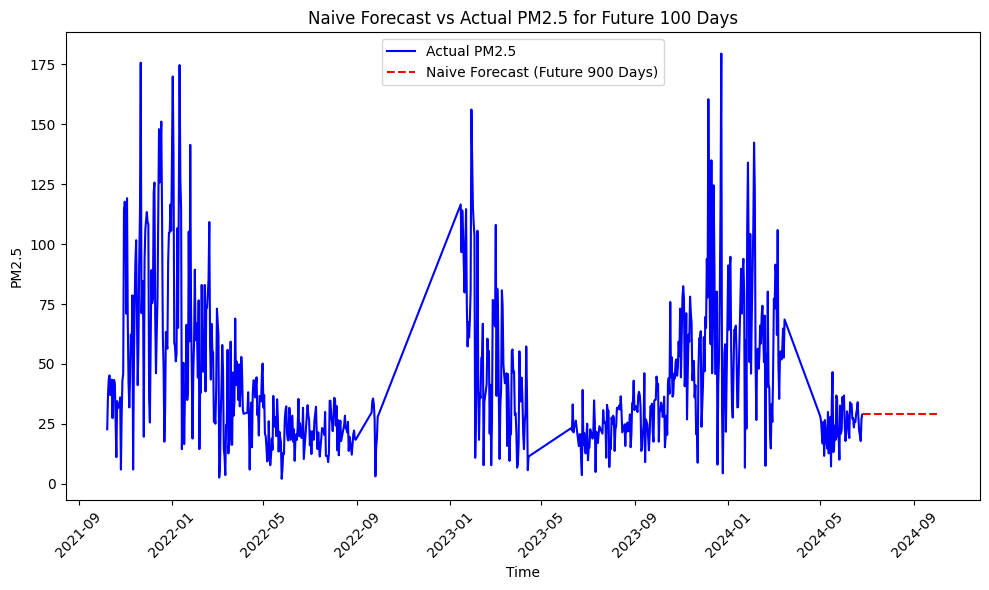

In [39]:
last_known_value = df_time_series['pm2.5_avg'].iloc[-1]
future_index = pd.date_range(df_time_series.index[-1] + pd.Timedelta(days=1), periods=100, freq='D')

future_forecast_values = [last_known_value] * 100

df_future_forecast = pd.DataFrame(future_forecast_values, index=future_index, columns=['Naive_Forecast'])
plt.figure(figsize=(10, 6))
plt.plot(df_time_series.index, df_time_series['pm2.5_avg'], label='Actual PM2.5', color='blue')
plt.plot(df_future_forecast.index, df_future_forecast['Naive_Forecast'], label='Naive Forecast (Future 900 Days)', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.title('Naive Forecast vs Actual PM2.5 for Future 100 Days')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
